In [1]:
%pip install pandas

You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
raw_recipes = pd.read_csv('static/data/RAW_recipes_cut.csv')
pp_recipes = pd.read_csv('static/data/PP_recipes_cut.csv')
interactions = pd.read_csv('static/data/RAW_interactions_cut.csv')


In [10]:
recipes_review_merge = pd.merge(raw_recipes, interactions, left_on='id',right_on='recipe_id', how='inner')
recipes_review = recipes_review_merge[['id', 'name', 'minutes', 'tags', 'ingredients', 'steps','description', 'rating','review']]

df2 = pd.DataFrame(recipes_review)
df2['avg_rating']  = df2.groupby('id')['rating'].transform('mean')
df_review = df2.groupby('id')['review'].agg(list).reset_index()
df2 = df2.drop(['rating', 'review'], axis=1).drop_duplicates()
result = pd.merge(df2, df_review, on='id', how='inner')

recipes = []

for index, row in result.iterrows():
  review = row['review']
  review = ''.join(str(x) for x in review)
  recipes.append((row["name"], str(row["tags"]), str(row["tags"])+str(row['name'])+str(row["steps"])+str(row["description"])+str(row["review"]), review))


In [5]:
%pip install scikit-learn

You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [6]:
%pip install scipy

You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
vectorizer = TfidfVectorizer(stop_words = ['english', 'time-to-make', 'course', 'cuisine', 'main-ingredient', 'occasion', 'equipment', 'preparation'], max_df = .8, min_df = 1)
td_matrix = vectorizer.fit_transform([x[2] for x in recipes])


/Users/alinayuan/Desktop/Cornell/DNMsKitchen/sql_template/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ingredient', 'main', 'make', 'time', 'to'] not in stop_words.
  % sorted(inconsistent)


In [12]:
from scipy.sparse.linalg import svds
u, s, v_trans = svds(td_matrix, k=100)

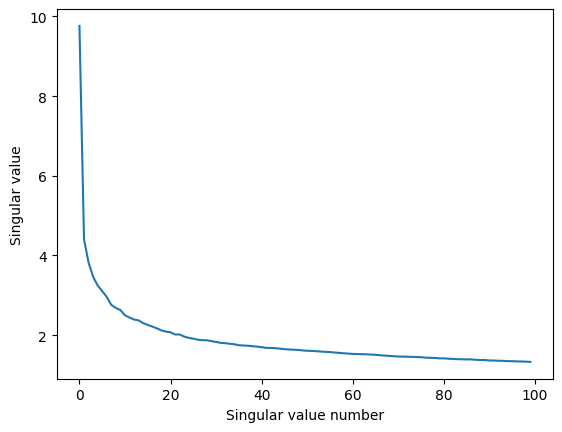

In [13]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(s[::-1])
plt.xlabel("Singular value number")
plt.ylabel("Singular value")
plt.show()

In [15]:
docs_compressed, s, words_compressed = svds(td_matrix, k=40)
words_compressed = words_compressed.transpose()
print(words_compressed.shape)
print(docs_compressed.shape)

(13326, 40)
(986, 40)


In [17]:
word_to_index = vectorizer.vocabulary_
index_to_word = {i:t for t,i in word_to_index.items()}

words_compressed_normed = normalize(words_compressed, axis = 1)

In [18]:
def closest_words(word_in, words_representation_in, k = 10):
    if word_in not in word_to_index: return "Not in vocab."
    sims = words_representation_in.dot(words_representation_in[word_to_index[word_in],:])
    asort = np.argsort(-sims)[:k+1]
    return [(index_to_word[i],sims[i]) for i in asort[1:]]

In [19]:
td_matrix_np = td_matrix.transpose().toarray()
td_matrix_np = normalize(td_matrix_np)

In [26]:
word = 'refreshing'
print("Using SVD:")
for w, sim in closest_words(word, words_compressed_normed):
  try:
    print("{}, {:.3f}".format(w, sim))
  except:
    print("word not found")
print()


Using SVD:
glasses, 0.844
ice, 0.816
goblets, 0.791
shears, 0.786
floats, 0.786
ripple, 0.786
beverages, 0.784
presentation, 0.766
cold, 0.762
served, 0.762



In [27]:
docs_compressed_normed = normalize(docs_compressed)

def closest_projects_to_word(word_in, k = 5):
    if word_in not in word_to_index: return "Not in vocab."
    sims = docs_compressed_normed.dot(words_compressed_normed[word_to_index[word_in],:])
    asort = np.argsort(-sims)[:k+1]
    return [(i, recipes[i][0],sims[i]) for i in asort[1:]]

In [31]:
query = "i want an easy and sweet recipe that is really simple"
query_tfidf = vectorizer.transform([query]).toarray()
query_vec = normalize(np.dot(query_tfidf, words_compressed)).squeeze()

def closest_projects_to_query(query_vec_in, k = 5):
    sims = docs_compressed_normed.dot(query_vec_in)
    asort = np.argsort(-sims)[:k+1]
    return [(i, recipes[i][0],sims[i]) for i in asort[1:]]

for i, proj, sim in closest_projects_to_query(query_vec):
    print("({}, {}, {:.4f}".format(i, proj, sim))

(266, corn dog casserole, 0.5196
(843, winnipeg chicken curry, 0.5089
(419, puppy chow snack mix, 0.4803
(369, tofu mayonnaise, 0.4703
(473, mammy s apple crisp, 0.4663


In [32]:
for i in range(40):
    print("Top words in dimension", i)
    dimension_col = words_compressed[:,i].squeeze()
    asort = np.argsort(-dimension_col)
    print([index_to_word[i] for i in asort[:10]])
    print()

Top words in dimension 0
['salmon', 'spinach', 'phyllo', 'coconut', 'sauce', 'vinegar', 'roast', 'oven', 'biscuits', 'sheet']

Top words in dimension 1
['salmon', 'pineapple', 'peppers', 'lemon', 'marinade', 'scones', 'milk', 'sugar', 'pudding', 'chili']

Top words in dimension 2
['salmon', 'vinegar', 'punch', 'curry', 'american', 'crab', 'vinegars', 'bars', 'coffee', 'you']

Top words in dimension 3
['cup', 'pumpkin', 'spinach', 'orange', 'punch', 'phyllo', 'butter', 'enchiladas', 'biscuits', 'fudge']

Top words in dimension 4
['cheese', 'biscuits', 'heat', 'crust', 'chops', 'sausage', 'pizza', 'high', 'skillet', 'fish']

Top words in dimension 5
['orange', 'scones', 'punch', 'beat', 'vinegar', 'egg', 'biscuits', 'you', 'chocolate', 'juice']

Top words in dimension 6
['punch', 'shrimp', 'bars', 'ice', 'marinade', 'these', 'lemon', 'dressing', 'pasta', 'coffee']

Top words in dimension 7
['pasta', 'biscuits', 'coffee', 'pineapple', 'peppers', 'orange', 'vinegar', 'sausage', 'zucchini',